In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

import scipy
scipy.derivative = scipy.misc.derivative
import pymc



Below is an example of a simulated datasets with 4 Gaussian components, with observational errors, and our fit to those data.

BIC [4820.648590800718, 4765.2795092672313, 4723.1893225294343, 4726.381031194529, 4753.5123006559397, 4765.3142711963792, 4783.8797691576201, 4802.6172096826413, 4820.9909874307705, 4845.9146668516623]
m_best= GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


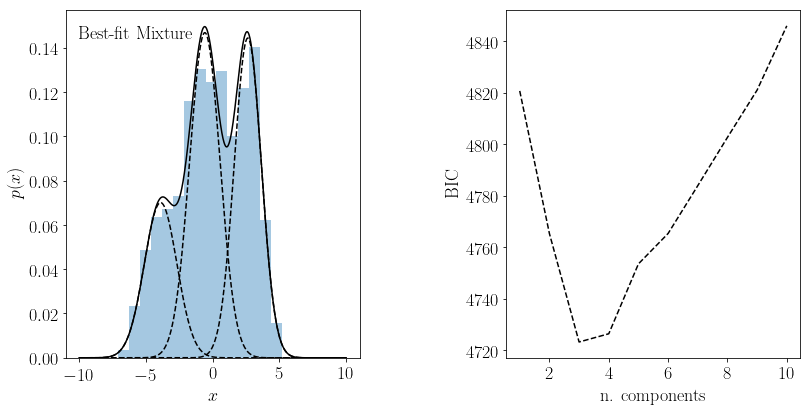

In [2]:
### Modeled after astroML book figure 4.2  

from sklearn.mixture import GaussianMixture as GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand.
    np.random.seed(0)
    
    xx=np.zeros((Ndata,1))
    gmm = GMM(n_components=4, max_iter=1)
    #print('gmm.means_=',gmm.means_, 'gmm.covariances_=',gmm.covariances_ , 'gmm.weights_=', gmm.weights_)
    gmm.means_ = np.array([[-4], [-1], [0.9], [3]])
    gmm.covariances_ = np.array([[[1.21]], [[1.0]], [[0.7]], [[0.8]]]) ** 2
    gmm.weights_ = np.array([0.2, 0.3, 0.2, 0.3])
    gmm.converged_='True' #hack
    gmm.precisions_cholesky_=1./gmm.covariances_ #hack

    x1 = gmm.sample(n_samples=Ndata)
    # convolution by "measurement" errors
    x2 = np.random.normal(x1[0], noiseStd)
    
    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    #print (x2)
    
    N = np.arange(1, 11)

    models = [None for i in range(len(N))]
    
    
    
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i]).fit(x2)

    # compute the BIC
    BIC = [m.bic(x2) for m in models]
    print('BIC', BIC)
#    BIC1 = [m.bic(y1) for m in models]
#    print('BIC1', BIC1)

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]
    
    print('m_best=', M_best )
    

    x = np.linspace(-10, 10, 1000)
    
    logprob = M_best.score_samples(x.reshape((-1,1)))## fix
    responsibilities = M_best.predict_proba(x.reshape((-1,1)))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(x2, 'auto', density=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()
    
doGMM(1000)    

BIC [24158.796594351632, 23793.19506705258, 23506.872401286335, 23447.16827182514, 23486.848122142845, 23516.56405474761, 23541.222266915032, 23567.507146805274, 23585.332664522473, 23612.68142146575]
m_best= GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


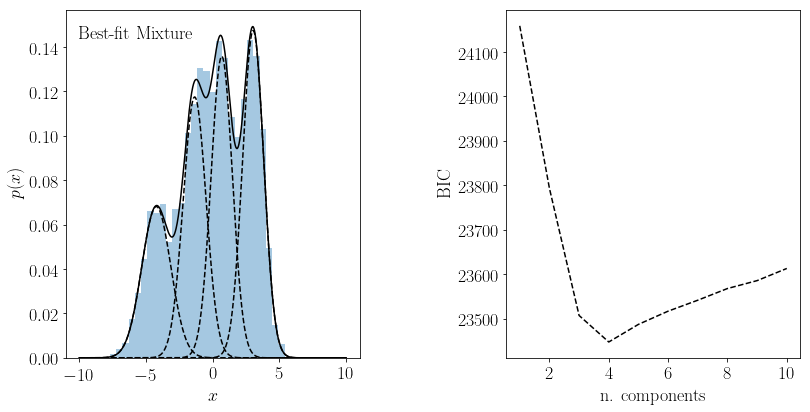

In [3]:
doGMM(5000)

**Conclusion** Large sample size helps! I love surveys, I love LSST! 

But one more thing: let's convolve our data with an arbitrary Gaussian 
to simulate measurement errors. 

BIC [25454.737929315186, 25345.508992676158, 25369.898971991177, 25402.23580522729, 25439.609861884874, 25447.144223140469, 25485.501750997897, 25500.064275619239, 25521.83344032909, 25553.742535108693]
m_best= GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


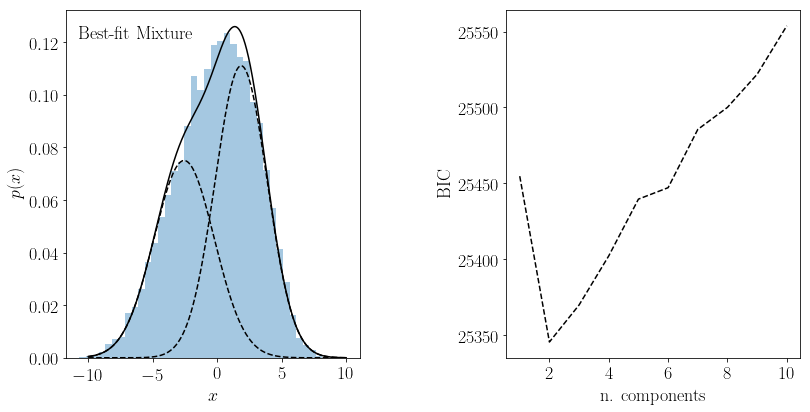

In [4]:
doGMM(5000,1.5)

**Conclusion** Duh! If you badly "blur" your sample, of course you will not see the fine
structure (i.e. many components)! 

Therefore, even with large samples, you still need to have precise and well calibrated 
measurements! Another reason to love LSST! 
 